# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pandarallel import pandarallel

# Loading the Files

Download the csv files into the `data/` directory.

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                         

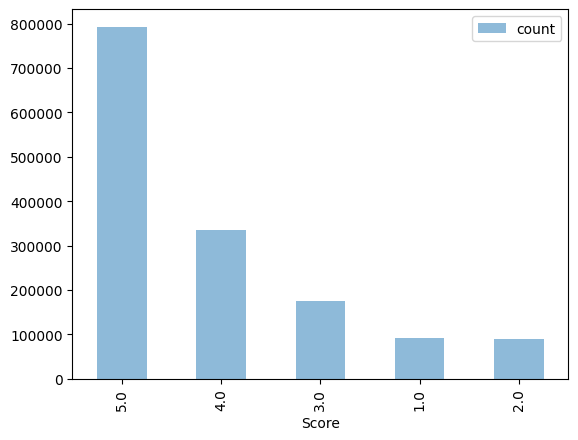


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
pandarallel.initialize(progress_bar=False)

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [35]:
def add_features_to(df):
    # This is where you can do all your feature extraction
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Add the vader sentiment analysis
    analyzer = SentimentIntensityAnalyzer()
    df['vader component (body)'] = df['Text'].fillna('').parallel_apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df['vader pos/neu/neg (body)'] = df['vader component (body)'].parallel_apply(lambda x: 1 if x >= 0.05 else (0 if x > -0.05 else -1))
    df['vader component (header)'] = df['Text'].fillna('').parallel_apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df['vader pos/neu/neg (header)'] = df['vader component (header)'].parallel_apply(lambda x: 1 if x >= 0.05 else (0 if x > -0.05 else -1))

    df['combined vader'] = (0.6 * (df['vader component (body)'] + df['vader pos/neu/neg (header)']) + 0.4 * (df['vader component (header)'] + df['vader pos/neu/neg (header)'])) / 2

    df['length'] = df['Text'].fillna('').parallel_apply(lambda x: len(x))                                           # the length of the review
    df['word count'] = df['Text'].fillna('').parallel_apply(lambda x: len(x.strip().split()))                       # the number of words in the review
    df['avg word length'] = (df['length'] / df['word count']).fillna(0)                                             # the average word length in the review
    df['unique words'] = df['Text'].fillna('').parallel_apply(lambda x: len(set(x.strip().split())))                # the number of unique words in the review
    df['vocab richness'] = (df['unique words'] / df['word count']).fillna(0)                                        # the ratio of unique words to total words in the review

    df['user reviews'] = df['UserId'].value_counts()                                                                # the number of reviews the user has written
    df['product reviews'] = df['ProductId'].value_counts()                                                          # the number of reviews the product has received

    # the average score of a given user/product id:
    def average_score(id, type='user'):
        if type == 'user':
            reviews = df[df['UserId'] == id]
        elif type == 'product':
            reviews = df[df['ProductId'] == id]
        if not reviews.empty:
            avg_score = reviews['Score'].mean()
            return avg_score
        else:
            return None
    
    df['average user score'] = df['UserId'].parallel_apply(average_score)
    df['average product score'] = df['ProductId'].parallel_apply(average_score, type='product')

    df['user score deviation'] = df['Score'] - df['average user score']                                             # deviation from the user/product's average score
    df['product score deviation'] = df['Score'] - df['average product score']

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    print("X_train.csv shape is ", train.shape)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [36]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [ ]:
features = ['combined vader', 'Helpfulness', 'Time', 'user reviews', 'product reviews', 'average user score', 'average product score', 
            'user score deviation', 'product score deviation', 'length', 'word count', 'avg word length', 'unique words', 'vocab richness']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [32]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=50).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

In [ ]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [34]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)